In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

In [2]:
x = input("Enter a Stock Ticker")
df = yf.download(x)
today = datetime.today()
today = today.strftime("%Y %m %d")
#Make sure the the ranged entered is at least a year long
df = df.loc["2023-01-01":today].copy()
upper = 50
lower = 21
df.head()
df.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-09-16,216.539993,217.220001,213.919998,216.320007,216.320007,59357400
2024-09-17,215.750000,216.899994,214.500000,216.789993,216.789993,45519300
2024-09-18,217.550003,222.710007,217.539993,220.690002,220.690002,59894900
2024-09-19,224.990005,229.820007,224.630005,228.869995,228.869995,66781300
2024-09-20,229.970001,233.089996,227.619995,228.199997,228.199997,318582200


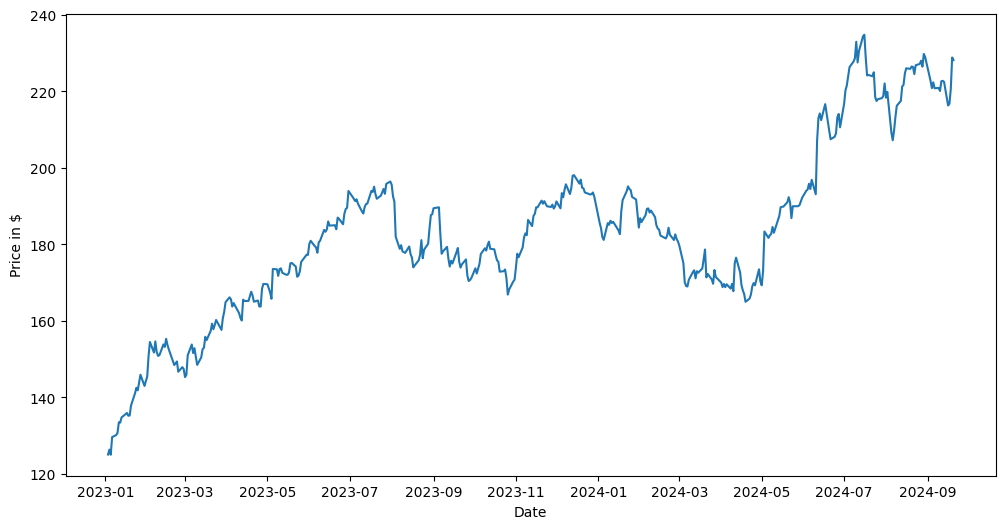

In [3]:
fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(111, ylabel='Price in $', xlabel='Date')
plt.plot(df.Close)

In [4]:
df = df.drop(['Adj Close'], axis=1)
df['maLow'] = df.Close.rolling(lower).mean()
df['maHigh'] = df.Close.rolling(upper).mean()

df.head()
df['SMAbullish'] = 0.0
df['SMAbullish'] = np.where(df['maLow'] > df['maHigh'], 1.0, 0.0)
df['SMAcrossover'] = df['SMAbullish'].diff()

Text(0.5, 1.0, 'AAPL SMA Crossover')

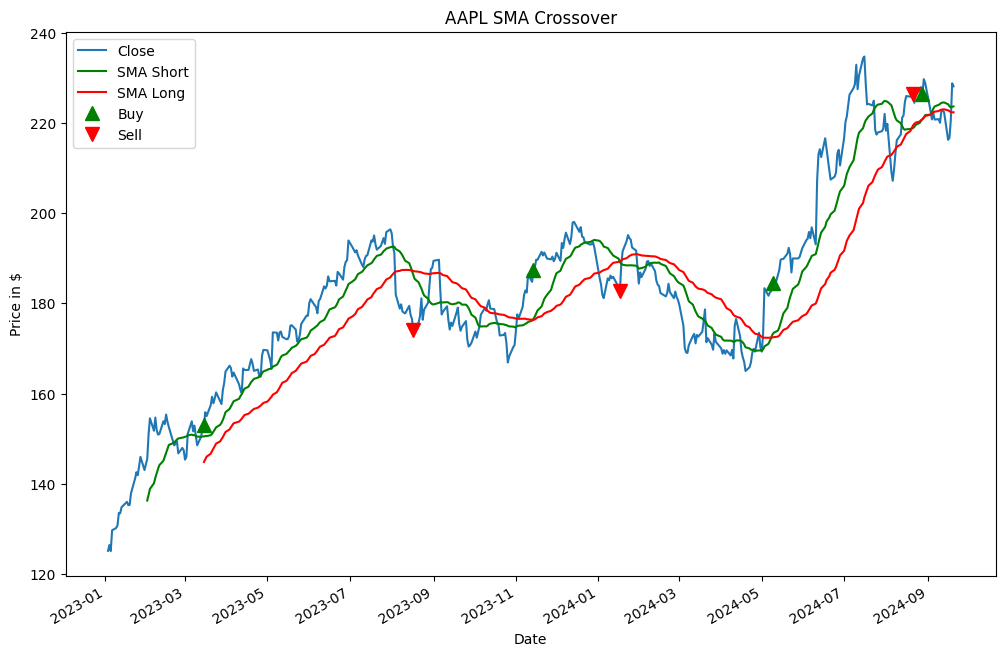

In [5]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111, ylabel='Price in $')

df['Close'].plot(ax=ax1)
df['maLow'].plot(ax=ax1, color='g')
df['maHigh'].plot(ax=ax1, color='r')

ax1.plot(df.loc[df.SMAcrossover == 1.0].index, 
         df.Close[df.SMAcrossover == 1.0],
         '^', markersize=10, color='g')
ax1.plot(df.loc[df.SMAcrossover == -1.0].index, 
         df.Close[df.SMAcrossover == -1.0],
         'v', markersize=10, color='r')
plt.legend(['Close', 'SMA Short', 'SMA Long', 'Buy', 'Sell'])
plt.title(x +' SMA Crossover')


Text(0.5, 1.0, 'AAPL EMA Crossover')

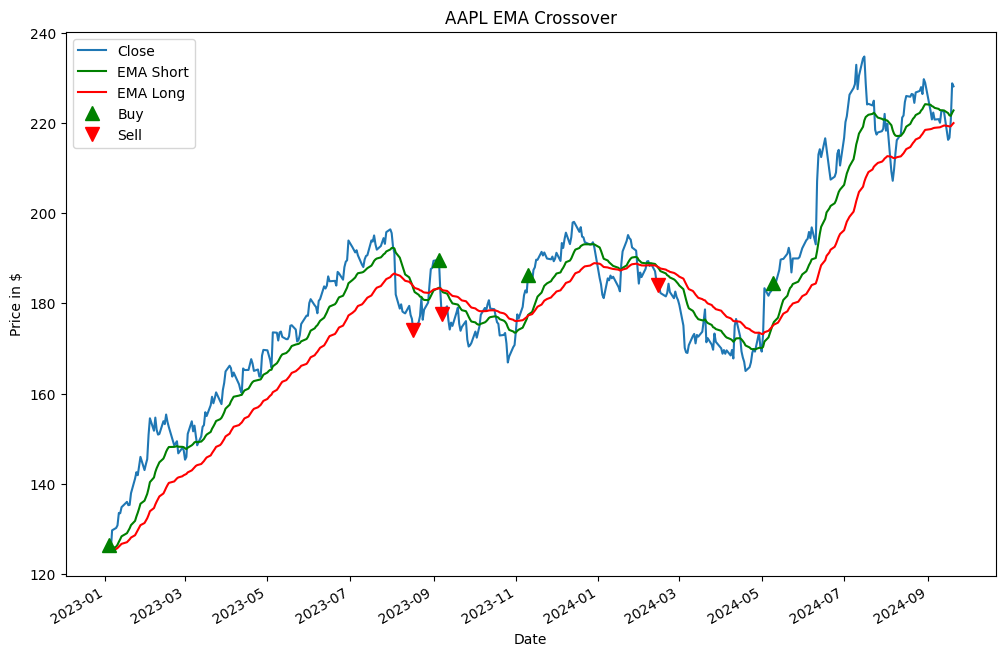

In [6]:
df['ema_short'] = df['Close'].ewm(span=lower, adjust=False).mean()
df['ema_long'] = df['Close'].ewm(span=upper, adjust=False).mean()

df['EMAbullish'] = 0.0
df['EMAbullish'] = np.where(df['ema_short'] > df['ema_long'], 1.0, 0.0)
df['EMAcrossover'] = df['EMAbullish'].diff()



fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111, ylabel='Price in $')

df['Close'].plot(ax=ax1)
df['ema_short'].plot(ax=ax1, color='g')
df['ema_long'].plot(ax=ax1, color='r')

ax1.plot(df.loc[df.EMAcrossover == 1.0].index, 
         df.Close[df.EMAcrossover == 1.0],
         '^', markersize=10, color='g')
ax1.plot(df.loc[df.EMAcrossover == -1.0].index, 
         df.Close[df.EMAcrossover == -1.0],
         'v', markersize=10, color='r')
plt.legend(['Close', 'EMA Short', 'EMA Long', 'Buy', 'Sell'])
plt.title(x +' EMA Crossover')

In [7]:
def rating():

    SMAdistancePercent = df['maLow'].iloc[-1] / df['maHigh'].iloc[-1]
    SMAdistancePercentFactor = SMAdistancePercent / 1.15

    EMAdistancePercent = df['ema_short'].iloc[-1] / df['ema_long'].iloc[-1]
    EMAdistancePercentFactor = EMAdistancePercent / 1.1

    PriceTrend = 0
    if(df['Close'].iloc[-252] < df['Close'].iloc[-1]):
        PriceTrend += 0.25
    if(df['Close'].iloc[-126] < df['Close'].iloc[-1]):
        PriceTrend += 0.25
    if(df['Close'].iloc[-28] < df['Close'].iloc[-1]):
        PriceTrend += 0.25
    if(df['Close'].iloc[-5] < df['Close'].iloc[-1]):
        PriceTrend += 0.25


    dy = np.gradient(df['ema_short'])
    EMALowTrend = 0

    if(dy[-1] > dy[-5]):
        EMALowTrend += 0.4
    if(dy[-1] > dy[-28]):
        EMALowTrend += 0.3
    if(dy[-1] > dy[126]):
        EMALowTrend += 0.2
    if(dy[-1] > 0):
        EMALowTrend += 0.1



    dySMA = np.gradient(df['maLow'])
    SMALowTrend = 0

    if(dySMA[-1] > dySMA[-5]):
        SMALowTrend += 0.4
    if(dySMA[-1] > dySMA[-28]):
        SMALowTrend += 0.3
    if(dySMA[-1] > dySMA[126]):
        SMALowTrend += 0.2
    if(dySMA[-1] > 0):
        SMALowTrend += 0.1

    currentBelowShorter = 0
    if(df['Close'].iloc[-1] > df['maLow'].iloc[-1]):
        currentBelowShorter += 0.5

    if(df['Close'].iloc[-1] > df['ema_short'].iloc[-1]):
        currentBelowShorter += 0.5


    currentBelowLonger = 0
    if(df['Close'].iloc[-1] > df['maHigh'].iloc[-1]):
        currentBelowLonger += 0.5

    if(df['Close'].iloc[-1] > df['ema_long'].iloc[-1]):
        currentBelowLonger += 0.5

    FinalStockRating = SMAdistancePercentFactor * 0.2 + EMAdistancePercentFactor * 0.2 + PriceTrend * 0.2 + SMALowTrend * 0.1 + EMALowTrend * 0.1 + currentBelowShorter * 0.1 + currentBelowLonger * 0.1
    return FinalStockRating

buyRating = str(round(rating() * 100, 3)) + "%"
print(buyRating)

93.907%
